In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt # general plotting
import cartopy.crs as ccrs # plot on maps, better than the Basemap module
import re
import scipy.interpolate
from scipy.interpolate import interp1d

In [3]:
ds = xr.open_dataset(".././initial_GEOSChem_rst.2x25_benchmark.nc")
ds # same as print(ds) in IPython/Jupyter environment

<xarray.Dataset>
Dimensions:       (lat: 91, lev: 72, lon: 144, time: 1)
Coordinates:
  * lon           (lon) float64 -180.0 -177.5 -175.0 -172.5 -170.0 -167.5 ...
  * lat           (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 ...
  * lev           (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * time          (time) datetime64[ns] 2013-07-01
Data variables:
    AREA          (lat, lon) float64 ...
    SPC_RCOOH     (time, lev, lat, lon) float32 ...
    SPC_O2        (time, lev, lat, lon) float32 ...
    SPC_N2        (time, lev, lat, lon) float32 ...
    SPC_MOH       (time, lev, lat, lon) float32 ...
    SPC_H2        (time, lev, lat, lon) float32 ...
    SPC_O         (time, lev, lat, lon) float32 ...
    SPC_HO2       (time, lev, lat, lon) float32 ...
    SPC_O1D       (time, lev, lat, lon) float32 ...
    SPC_OH        (time, lev, lat, lon) float32 ...
    SPC_MO2       (time, lev, lat, lon) float32 ...
    SPC_MCO3      (time, lev, lat, lon) float32 ...
 

In [44]:
#get list of molecules
molec = list()
pattern = "(SPC_\w+)"
for i, line in enumerate(open('../molecular_species.txt')):
    for match in re.finditer(pattern,line):
        molec.append(match.group())

In [45]:
#initialize NetCDF-4
dataset = xr.Dataset()
dataset.coords['time'] = ds.coords['time']
lev = np.linspace(1,132,num =132,dtype = 'float64')
dataset.coords['lev'] = (('lev'),lev)
dataset.coords['lat'] = ds.coords['lat'] 
dataset.coords['lon'] = ds.coords['lon']
dataset.attrs['title'] = 'GEOS-5 132 lvl restart'
dataset.attrs['history'] = 'created by Ada Shaw with initial_GEOSChem_rst.c48_benchmark.nc'
dataset.attrs['format'] = "NetCDF-4"
dataset.attrs['conventions'] = 'COARDS'
dataset['AREA'] = ds['AREA']

In [46]:
#find dimensions of model output
lon_dim = len(ds['lon'].values)
lat_dim = len(ds['lat'].values)


In [65]:
#initialize variables for interpolation
conc_interp = np.ndarray(shape=(1,132,lat_dim,lon_dim), dtype='f', order='F')
lon_i =np.linspace(1,lon_dim,num= lon_dim,dtype ='float64')
lev72 = np.linspace(1,72, num=72,dtype = 'float64')
lev132 = np.linspace(1,72, num=132,dtype = 'float64')

In [68]:
#loop to save interpolated concentrations of species
for tick_molec in range(len(molec)):
    conc_interp = np.ndarray(shape=(1,132,lat_dim,lon_dim), dtype='f', order='F')
    dr = ds[molec[tick_molec]].values
    for tick_lat in range(lat_dim):
        interp = scipy.interpolate.interp2d(lon_i,lev72 ,dr[0,:,tick_lat,:], kind='linear')
        conc_interp[0,:,tick_lat,:] = interp(lon_i,lev132)
    dataset[molec[tick_molec]] = (('time','lev','lat','lon'),conc_interp)
    dataset.data_vars[molec[tick_molec]].attrs = ds.data_vars[molec[tick_molec]].attrs

In [63]:
#check if loop works using ozone as example
conc_interp = np.ndarray(shape=(1,132,lat_dim,lon_dim), dtype='f', order='F')
lon_i =np.linspace(1,lon_dim,num= lon_dim,dtype ='float64')
lev72 = np.linspace(1,72, num=72,dtype = 'float64')
lev132 = np.linspace(1,72, num=132,dtype = 'float64')
tick_molec = 275
dr = ds[molec[tick_molec]].values
for tick_lat in range(lat_dim):
    interp = scipy.interpolate.interp2d(lon_i,lev72 ,dr[0,:,tick_lat,:], kind='linear')
    conc_interp[0,:,tick_lat,:] = interp(lon_i,lev132)
dataset[molec[tick_molec]] = (('time','lev','lat','lon'),conc_interp)
dataset.data_vars[molec[tick_molec]].attrs = ds.data_vars[molec[tick_molec]].attrs

Text(0.5,1,'Ozone profile at $(30^{\\circ}N, 60^{\\circ}E)$')

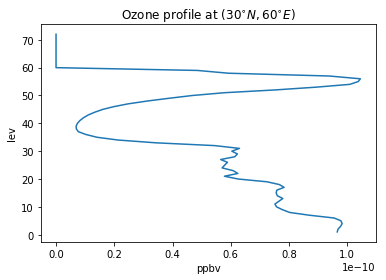

In [73]:
#check if ozone profiles are similar
#72 levels
do3 = ds["SPC_CO2"]
lev_72 = do3.sel(lon = 175.0,lat = 30,time = '2013-07-01T00:00:00.000000000')

plt.plot(lev_72, lev_72['lev'])
plt.ylabel('lev');plt.xlabel('ppbv')
plt.title('Ozone profile at $(30^{\circ}N, 60^{\circ}E)$')


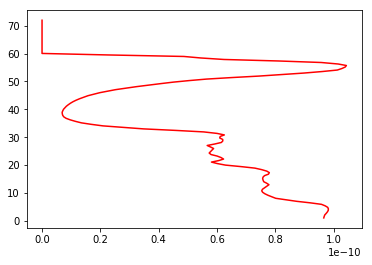

In [72]:
#132 levels
do3_interp = dataset['SPC_CO2']
lev_132 = do3_interp.sel(lon = 175.,lat = 30.,time = "2013-07-01T00:00:00.000000000")
plt.plot(lev_132, np.linspace(1,72,num=132),'r')

In [ ]:
ds['lon'].values

In [ ]:
ds['lat'].values

In [ ]:
ds.coords['time']

In [71]:
dataset

<xarray.Dataset>
Dimensions:       (lat: 91, lev: 132, lon: 144, time: 1)
Coordinates:
  * time          (time) datetime64[ns] 2013-07-01
  * lev           (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ...
  * lat           (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 ...
  * lon           (lon) float64 -180.0 -177.5 -175.0 -172.5 -170.0 -167.5 ...
Data variables:
    AREA          (lat, lon) float64 ...
    SPC_RCOOH     (time, lev, lat, lon) float32 1e-20 1e-20 1e-20 1e-20 ...
    SPC_O2        (time, lev, lat, lon) float32 0.2095 0.2095 0.2095 0.2095 ...
    SPC_N2        (time, lev, lat, lon) float32 0.7808 0.7808 0.7808 0.7808 ...
    SPC_MOH       (time, lev, lat, lon) float32 2e-09 2e-09 2e-09 2e-09 ...
    SPC_H2        (time, lev, lat, lon) float32 5e-07 5e-07 5e-07 5e-07 ...
    SPC_O         (time, lev, lat, lon) float32 1e-30 1e-30 1e-30 1e-30 ...
    SPC_HO2       (time, lev, lat, lon) float32 1.4181342e-16 1.4181342e-16 ...
    SPC_O1D       (time, lev

In [18]:
#save to netCDF
dataset.to_netcdf('132_lvl_benchmark_rst.nc','w')